Write  a colab  tensorflow only from scratch not using high level api  of the same



In [103]:
#import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as pltgo

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
     

In [104]:
#Sample input
def get_true_labels(X, weights_true, bias_true):
  return tf.matmul(X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)
     

In [105]:
n_samples = 250
input_dim = 3
output_dim = 2

tf.random.set_seed(4)
X = tf.random.uniform((n_samples, input_dim), -1, 1)
print('Sample X: ' + str(X[:2]))

weights_true = tf.constant([[5., -2., 1.], [2., -2., 4.]], dtype=tf.float32)
bias_true = tf.constant([[1], [1]], dtype=tf.float32)

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:2]))

Sample X: tf.Tensor(
[[ 0.9513366   0.11241102 -0.84529805]
 [-0.6738503  -0.71098256 -0.73748803]], shape=(2, 3), dtype=float32)
Sample y: tf.Tensor(
[[9.901027   3.9395843 ]
 [0.11849296 0.19702268]], shape=(2, 2), dtype=float32)


In [106]:
#plot 3D data
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()
     

In [107]:
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()
     

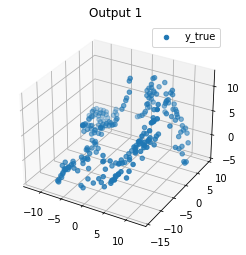

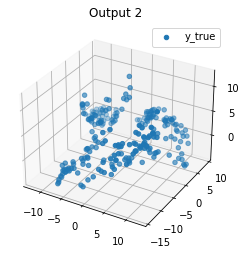

In [108]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])
     


In [109]:
X_reduced = TSNE(n_components=2).fit_transform(X)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X_reduced,y_true_reduced)

#Build neural network

In [110]:
#Mean Square Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

#Linear Layer

In [111]:
class Layer:

  #Randomly initialize the weight and bias
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = tf.random.uniform((num_input_nodes, num_output_nodes), -1, 1)
    self.bias = tf.random.uniform((1, 1), -1, 1)
    self.X = tf.zeros([num_input_nodes])
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  #Compute forward pass
  def forward(self, X):
    self.X = X
    self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  #Perform gradient descent
  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)
    
    self.dJdW = tf.matmul(self.X, curr_upstream_gradient, transpose_a=True)
    self.dJdb = tf.reduce_sum(curr_upstream_gradient, 1)
    self.dJdX = tf.matmul(curr_upstream_gradient, self.weights, transpose_b=True)
    return self.dJdX

  # Update weight and bias params with learning rate step size
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(
        self.num_input_nodes, self.num_output_nodes, self.activation,
        self.X, self.weights, self.bias)



In [112]:
#ReLu activation 
class Relu:
  def __init__(self):
    self.input = tf.constant([], dtype=tf.float32)

  #Forward pass
  def forward(self, input):
    self.input = input
    self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
    return self.output
  
  def backward(self, upstream_gradient):
    return tf.where((self.input > 0), upstream_gradient, 0)
  
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

In [113]:
class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs
    for l in self.layers:
      curr_out = l.forward(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    gradient = loss_gradient
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#Hyperparameters

In [114]:
epochs = 150
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]
     

#Training Neural Network with ReLU

In [115]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0. 0.]
Weights:
[[ 0.8993137  -0.05180287 -0.6799309   0.8145659 ]
 [ 0.8228421  -0.01230907 -0.70659757  0.9294169 ]
 [ 0.26166105 -0.44371033 -0.91817045  0.6864929 ]]
Bias:[[0.09206796]]
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0. 0. 0.]
Weights:
[[ 0.63150287  0.96044135 -0.6330464 ]
 [ 0.29742074 -0.96691823  0.7850721 ]
 [-0.9131329   0.13237166  0.16325712]
 [-0.76590586  0.00552201 -0.13452601]]
Bias:[[0.7875974]]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0. 0.]
Weights:
[[ 0.23214531  0.51234055]
 [ 0.46729493 -0.96697617]
 [-0.7350838  -0.3941381 ]]
Bias:[[-0.792181]]

Error:  22.712076
Error:  21.534836
Error:  20.466715
Error:  19.468306
Error:  18.511745
Error:  17.574463
Error:  16.634811
Error:  15.685391
Error:  14.724163
Error:  13.749161
Error:  12.75807
Error:  11.770776
Error:  10.797184
Error:  9.851801
Error:  8.944799
Erro

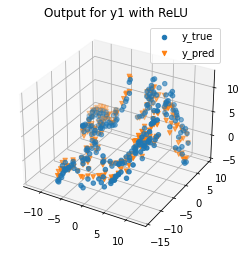

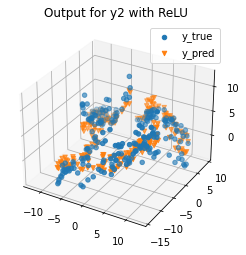

In [116]:
plot_3d('Output for y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 with ReLU', X, y_true[:,1], y_pred[:,1])
     


In [117]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)

#training neural network without activation

In [118]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
[0. 0. 0.]
Weights:
[[-0.35700798 -0.970232    0.4530878  -0.5754149 ]
 [ 0.90835404 -0.14789486  0.35019183  0.7755692 ]
 [ 0.6711004  -0.61123204 -0.3805008   0.19070148]]
Bias:[[0.3075807]]
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
[0. 0. 0. 0.]
Weights:
[[-0.05168366  0.43672252 -0.9954922 ]
 [-0.85245585  0.07808876 -0.45187974]
 [-0.6147814  -0.43732524 -0.59802413]
 [-0.41415405 -0.2941265  -0.01377487]]
Bias:[[-0.42177534]]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0. 0.]
Weights:
[[-0.79245114 -0.0391252 ]
 [ 0.0200882  -0.64736867]
 [-0.48062944 -0.38786006]]
Bias:[[0.98130894]]

Error:  14.230772
Error:  13.472159
Error:  12.945217
Error:  12.552719
Error:  12.242563
Error:  11.984257
Error:  11.758669
Error:  11.553064
Error:  11.358506
Error:  11.168398
Error:  10.977623
Error:  10.782004
Error:  10.57803
Error:  10.362586
Error:  10.132897


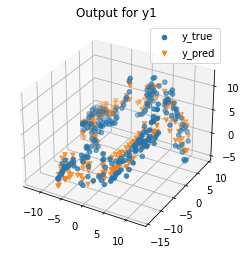

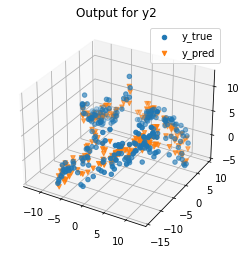

In [119]:
plot_3d('Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2', X, y_true[:,1], y_pred[:,1])

In [120]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)